# Reducing features by stats modeling

## Procedure

* Regress each cpg with age
* get p-values for each cpg for slope  not equal to 0
* Adjust pvalues for multiple testing, FDR = 0.01 (BH)
* Select 100 cpgs with lowest adjusted p values
* Make models with these 
* Compare to the XGboost crossvalidation method


## Conclusions:
* Works about as well as XGboost method slightly worse.
* After adjusting for multiple testing 148,948 cpgs significant of 375,603 were found significant (39.7%). 
* the two methods share 51 top100 cpgs in common

#### Imports

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
import os

#### Import our modules

In [2]:
from age_predict.Loading_EWAS_Aging_Data import *
from age_predict.Regression import *
from age_predict.Pickle_unpickle import *

In [38]:
path_to_save_features = '../saved_features/'
path_to_save_models = '../saved_models/'

In [24]:
# Set working directory
#os.chdir('/Users/dcox/Desktop/EWAS-organized/blood/feature_selection')

#### set tissue of interest

In [4]:
tissue_of_interest = 'whole blood'

#### Load data

In [5]:
%%time
file_in = './data/age_methylation_v1/age_methylation_v1.txt'
file_out = './data/age_methylation_v1/'+ tissue_of_interest + '_age_methylation_v1.txt'

df_t = load_EWAS_aging_by_tissue(file_in, file_out, search_term=tissue_of_interest,
                          num_rows='all', verbose=True)

finished line 10000
finished line 20000
finished line 30000
finished line 40000
finished line 50000
finished line 60000
finished line 70000
finished line 80000
finished line 90000
finished line 100000
finished line 110000
finished line 120000
finished line 130000
finished line 140000
finished line 150000
finished line 160000
finished line 170000
finished line 180000
finished line 190000
finished line 200000
finished line 210000
finished line 220000
finished line 230000
finished line 240000
finished line 250000
finished line 260000
finished line 270000
finished line 280000
finished line 290000
finished line 300000
finished line 310000
finished line 320000
finished line 330000
finished line 340000
finished line 350000
finished line 360000
finished line 370000
finished line 380000
finished line 390000
finished line 400000
finished line 410000
finished line 420000
finished line 430000
finished line 440000
finished line 450000
finished line 460000
finished line 470000
finished line 480000



#### Select age 20 and older

In [6]:
df_t_over20 = df_t[df_t.age >=20]

#### Split and impute data

In [7]:
%%time
df_p_working, df_p_saved = splitting_and_imputing(df_t_over20, input_percent=10, 
                                           fraction_test=0.25, seed=2021)

CPU times: user 3min 57s, sys: 44.8 s, total: 4min 42s
Wall time: 5min 9s


In [49]:
df_p_working

sample_id,tissue,age,cg02494853,cg03706273,cg04023335,cg05213048,cg15295597,cg26520468,cg27539833,cg00008945,cg00011200,cg00011891,cg00016522,cg00018261,cg00021786,cg00026186,cg00072288,cg00072839,cg00074638,cg00112256,cg00114625,cg00114913,cg00116709,cg00139317,cg00140085,cg00142683,cg00192980,cg00200463,cg00206414,cg00240113,cg00241296,cg00241907,cg00243584,cg00264378,cg00265812,cg00373606,cg00374088,cg00378717,cg00378950,cg00380985,cg00381376,cg00391044,cg00399450,cg00408231,cg00412010,cg00412368,cg00416689,cg00427681,cg00457389,cg00458505,...,cg27545494,cg27552198,cg27553637,cg27575890,cg27585287,cg27592453,cg27598806,cg27601574,cg27611781,cg27612019,cg27614432,cg27634071,cg27648216,cg27656573,cg27657363,cg27657537,cg27660038,cg27662611,cg27665648,ch.22.16108507R,ch.22.16454022F,ch.22.78028F,ch.22.17803970R,ch.22.107403R,ch.22.137888R,ch.22.22597277R,ch.22.217069R,ch.22.22928834R,ch.22.23746271F,ch.22.25752197R,ch.22.26167205F,ch.22.317144R,ch.22.26442001R,ch.22.28920330F,ch.22.30020508R,ch.22.427671F,ch.22.467397R,ch.22.31817810F,ch.22.33863861F,ch.22.533187F,ch.22.569473R,ch.22.38010425R,ch.22.707968R,ch.22.740407F,ch.22.757911F,ch.22.43177094F,ch.22.46830341F,ch.22.1008279F,ch.22.47579720R,ch.22.48274842R
GSM2334366,whole blood,94,0.078,0.205,0.139,0.904,0.120,0.970,0.912,0.276,0.616,0.602,0.577,0.612,0.888,0.551,0.415,0.112,0.672,0.526,0.641,0.367000,0.630,0.561,0.485,0.579,0.662,0.635,0.449,0.480,0.256,0.288,0.522,0.616,0.602,0.583,0.519,0.019,0.900,0.607,0.017,0.397,0.577,0.532,0.448,0.653,0.266,0.388,0.156,0.583,...,0.008,0.962,0.078,0.451,0.022,0.943,0.94800,0.962,0.064000,0.953,0.020,0.035,0.977,0.975,0.924,0.087,0.096,0.023000,0.882,0.001000,0.002000,0.012000,0.160,0.013,0.121,0.016,0.003000,0.014000,0.011,0.002,0.008,0.014000,0.009,0.018000,0.009000,0.017,0.005,0.010,0.045,0.011,0.109,0.016,0.003,0.006000,0.010000,0.004,0.010,0.001000,0.047,0.012
GSM989863,whole blood,101,0.013,0.008,0.117,0.756,0.033,0.958,0.933,0.324,0.509,0.519,0.529,0.629,0.955,0.490,0.318,0.072,0.664,0.569,0.594,0.475000,0.575,0.533,0.420,0.566,0.558,0.520,0.201,0.453,0.293,0.473,0.454,0.434,0.589,0.443,0.401,0.014,0.873,0.473,0.007,0.471,0.554,0.678,0.447,0.513,0.270,0.468,0.129,0.553,...,0.012,0.952,0.050,0.329,0.014,0.907,0.95200,0.967,0.067000,0.649,0.032,0.028,0.967,0.969,0.851,0.093,0.067,0.023000,0.856,0.002000,0.002000,0.021000,0.155,0.011,0.177,0.013,0.002000,0.007000,0.004,0.004,0.008,0.014000,0.012,0.020000,0.003000,0.017,0.002,0.009,0.061,0.008,0.152,0.015,0.005,0.008000,0.009000,0.002,0.009,0.001000,0.057,0.008
GSM1443696,whole blood,99,0.013,0.017,0.477,0.715,0.017,0.966,0.932,0.010,0.014,0.025,0.011,0.017,0.983,0.002,0.018,0.051,0.632,0.029,0.009,0.052000,0.015,0.018,0.059,0.033,0.035,0.025,0.033,0.038,0.034,0.012,0.285,0.008,0.018,0.021,0.060,0.013,0.933,0.051,0.006,0.088,0.018,0.964,0.152,0.099,0.010,0.238,0.008,0.005,...,0.010,0.964,0.082,0.447,0.007,0.859,0.97400,0.966,0.100000,0.746,0.014,0.020,0.973,0.979,0.861,0.033,0.082,0.032000,0.886,0.019000,0.005000,0.069000,0.161,0.001,0.111,0.002,0.014000,0.016000,0.016,0.002,0.002,0.019136,0.005,0.025557,0.011000,0.005,0.003,0.009,0.026,0.002,0.122,0.005,0.006,0.011000,0.027000,0.000,0.003,0.002000,0.033,0.003
GSM1069241,whole blood,99,0.013,0.017,0.477,0.715,0.017,0.966,0.932,0.010,0.014,0.025,0.011,0.017,0.983,0.002,0.018,0.051,0.632,0.029,0.009,0.052000,0.015,0.018,0.059,0.033,0.035,0.025,0.033,0.038,0.034,0.012,0.285,0.008,0.018,0.021,0.060,0.013,0.933,0.051,0.006,0.088,0.018,0.964,0.152,0.099,0.010,0.238,0.008,0.005,...,0.010,0.964,0.082,0.447,0.007,0.859,0.97400,0.966,0.100000,0.746,0.014,0.020,0.973,0.979,0.861,0.033,0.082,0.032000,0.886,0.019000,0.005000,0.069000,0.161,0.001,0.111,0.002,0.014000,0.016000,0.016,0.002,0.002,0.019136,0.005,0.025557,0.011000,0.005,0.003,0.009,0.026,0.002,0.122,0.005,0.006,0.011000,0.027000,0.000,0.003,0.002000,0.033,0.003
GSM1572442,whole blood,112,0.036,0.255,0.260,0.690,0.065,0.983,0.951,0.341,0.527,0.604,0.463,0.567,0.986,0.531,0.530,0.2

In [50]:
df_p_saved

sample_id,tissue,age,cg02494853,cg03706273,cg04023335,cg05213048,cg15295597,cg26520468,cg27539833,cg00008945,cg00011200,cg00011891,cg00016522,cg00018261,cg00021786,cg00026186,cg00072288,cg00072839,cg00074638,cg00112256,cg00114625,cg00114913,cg00116709,cg00139317,cg00140085,cg00142683,cg00192980,cg00200463,cg00206414,cg00240113,cg00241296,cg00241907,cg00243584,cg00264378,cg00265812,cg00373606,cg00374088,cg00378717,cg00378950,cg00380985,cg00381376,cg00391044,cg00399450,cg00408231,cg00412010,cg00412368,cg00416689,cg00427681,cg00457389,cg00458505,...,cg27545494,cg27552198,cg27553637,cg27575890,cg27585287,cg27592453,cg27598806,cg27601574,cg27611781,cg27612019,cg27614432,cg27634071,cg27648216,cg27656573,cg27657363,cg27657537,cg27660038,cg27662611,cg27665648,ch.22.16108507R,ch.22.16454022F,ch.22.78028F,ch.22.17803970R,ch.22.107403R,ch.22.137888R,ch.22.22597277R,ch.22.217069R,ch.22.22928834R,ch.22.23746271F,ch.22.25752197R,ch.22.26167205F,ch.22.317144R,ch.22.26442001R,ch.22.28920330F,ch.22.30020508R,ch.22.427671F,ch.22.467397R,ch.22.31817810F,ch.22.33863861F,ch.22.533187F,ch.22.569473R,ch.22.38010425R,ch.22.707968R,ch.22.740407F,ch.22.757911F,ch.22.43177094F,ch.22.46830341F,ch.22.1008279F,ch.22.47579720R,ch.22.48274842R
GSM1345728,whole blood,38,0.020,0.037,0.100,0.529,0.025,0.975,0.924,0.400,0.507,0.514,0.509,0.526,0.972,0.515,0.391,0.071,0.658,0.560,0.579,0.393,0.540,0.539,0.405,0.503,0.599,0.578,0.304,0.415,0.228,0.345,0.441,0.419,0.580,0.477,0.390,0.027,0.896,0.432,0.018,0.397,0.576,0.779,0.498,0.595,0.434,0.333,0.106,0.522,...,0.014,0.946,0.052,0.395,0.011,0.944,0.950,0.952,0.050,0.761,0.032,0.039,0.969,0.966,0.891,0.076,0.071,0.026,0.880,0.005,0.002,0.001000,0.126,0.010,0.123,0.009,0.000,0.010,0.014,0.006,0.000,0.023000,0.007,0.040,0.008,0.011,0.004,0.007,0.034,0.005,0.12600,0.015,0.001,0.009,0.010,0.007,0.012,0.003,0.041,0.009
GSM1425726,whole blood,79,0.042,0.039,0.647,0.854,0.067,0.968,0.934,0.009,0.015,0.013,0.010,0.015,0.977,0.005,0.019,0.124,0.612,0.028,0.006,0.038,0.013,0.007,0.094,0.038,0.038,0.053,0.296,0.129,0.026,0.027,0.360,0.010,0.021,0.040,0.072,0.007,0.910,0.052,0.007,0.085,0.013,0.957,0.183,0.091,0.017,0.430,0.019,0.066,...,0.008,0.975,0.053,0.373,0.015,0.874,0.958,0.966,0.040,0.929,0.019,0.050,0.973,0.974,0.892,0.050,0.072,0.020,0.881,0.002,0.003,0.009000,0.143,0.004,0.089,0.005,0.003,0.006,0.007,0.006,0.003,0.019136,0.007,0.007,0.001,0.007,0.002,0.000,0.025,0.007,0.13377,0.008,0.002,0.007,0.007,0.002,0.006,0.000,0.023,0.006
GSM1886430,whole blood,24,0.022,0.021,0.501,0.676,0.032,0.966,0.939,0.001,0.022,0.024,0.021,0.023,0.975,0.008,0.011,0.074,0.604,0.025,0.014,0.041,0.034,0.022,0.046,0.021,0.040,0.039,0.304,0.132,0.030,0.024,0.319,0.009,0.026,0.025,0.107,0.021,0.914,0.048,0.007,0.079,0.016,0.980,0.107,0.097,0.022,0.190,0.041,0.015,...,0.006,0.963,0.034,0.479,0.013,0.940,0.962,0.992,0.089,0.701,0.012,0.042,0.976,0.973,0.899,0.093,0.086,0.048,0.901,0.008,0.004,0.036000,0.191,0.003,0.172,0.009,0.010,0.013,0.012,0.003,0.005,0.016000,0.006,0.048,0.016,0.010,0.004,0.013,0.034,0.017,0.20100,0.009,0.007,0.009,0.011,0.004,0.010,0.003,0.057,0.004
GSM2337042,whole blood,25,0.016,0.030,0.120,0.534,0.028,0.974,0.924,0.308,0.497,0.570,0.486,0.516,0.977,0.507,0.447,0.089,0.658,0.599,0.578,0.488,0.632,0.536,0.437,0.510,0.552,0.542,0.231,0.484,0.195,0.436,0.450,0.376,0.606,0.450,0.322,0.011,0.905,0.534,0.011,0.437,0.617,0.619,0.434,0.543,0.229,0.449,0.142,0.501,...,0.005,0.964,0.042,0.438,0.008,0.889,0.964,0.942,0.049,0.694,0.025,0.021,0.986,0.958,0.854,0.055,0.036,0.028,0.924,0.003,0.009,0.006000,0.135,0.011,0.126,0.018,0.013,0.011,0.014,0.003,0.004,0.024000,0.006,0.068,0.018,0.017,0.007,0.012,0.038,0.017,0.09600,0.026,0.002,0.008,0.016,0.004,0.020,0.002,0.065,0.008
GSM1886440,whole blood,23,0.013,0.011,0.607,0.862,0.090,0.957,0.871,0.000,0.017,0.025,0.022,0.011,0.983,0.004,0.022,0.050,0.617,0.029,0.006,0.134,0.022,0.017,0.041,0.017,0.026,0.031,0.403,0.092,0.019,0.027,0.314,0.020,0.027,0.016,0.056,0.018,0.854,0.026,0.014,0.06

## HERE STARTS THE STATS ANALYSIS

In [8]:
df_processed_imp_over20 = df_p_working

### Regressing each cpg on age

In [9]:
%%time
import statsmodels.api as sm

p_values = []
slopes = []
cpgs = []
y = df_processed_imp_over20['age']
for i, cpg in enumerate(df_processed_imp_over20.columns[2:]):
    X = df_processed_imp_over20[cpg]
    X = sm.add_constant(X)
    fit = sm.OLS(y, X).fit()
    p_values.append(fit.pvalues[1])
    slopes.append(fit.params[1])
    if i % 10000 == 0:
        print(i, cpg, fit.pvalues[1], fit.params[1])

0 cg02494853 3.7694711013825014e-05 109.1102451144472
10000 cg18395233 2.5347216034277503e-05 -80.8727102275237
20000 cg22475904 0.5722415010614574 -56.08104271607084
30000 cg17378483 0.008523204061234543 -284.5575574787013
40000 cg09295542 0.06922861451114537 -25.45126344779563
50000 cg17495792 0.039582205592826596 -93.16145792532843
60000 cg03943218 9.126767073561638e-24 147.82120116102618
70000 cg18519694 0.00020673880674197142 40.47922122864131
80000 cg15988970 0.8185538849982108 1.3735697689378803
90000 cg03622875 0.6153501846111435 33.50495235777683
100000 cg19500275 0.6782779291948458 -21.14645466451135
110000 cg22598669 0.032182775862453356 -31.78830169271285
120000 cg09413198 0.008646430611345512 -23.159485353854855
130000 cg06840154 7.862391350796803e-29 -147.72077712489377
140000 cg17493193 0.25648836511167517 -31.642837546017603
150000 cg01479187 8.27942108389442e-16 -52.53628102782083
160000 cg16450590 0.03525714752596321 24.941430341570424
170000 cg05988143 0.558489886494

### Geting pvalues into a dataframe

In [10]:
df_pvals = pd.DataFrame({'cpgs': df_processed_imp_over20.columns[2:], 'slopes': slopes, 'p_values': p_values})

In [11]:
df_pvals

,cpgs,slopes,p_values
0,cg02494853,109.110245,3.769471e-05
1,cg03706273,98.158819,1.945042e-11
2,cg04023335,0.580067,8.363296e-01
3,cg05213048,16.638899,3.178471e-03
4,cg15295597,128.464464,2.242176e-10
...,...,...,...
375596,ch.22.43177094F,-1183.430819,1.999600e-07
375597,ch.22.46830341F,-494.145461,1.633536e-05
375598,ch.22.1008279F,-68.195858,7.091383e-01
375599,ch.22.47579720R,-18.132566,7.554444e-01


In [12]:
# sorting 
df_pvals_sorted = df_pvals.sort_values('p_values', ascending=True)
df_pvals_sorted

,cpgs,slopes,p_values
42226,cg16867657,165.608835,0.000000e+00
85346,cg04875128,138.752289,3.440701e-281
19997,cg22454769,144.500157,1.234092e-251
44462,cg24724428,177.142576,4.943874e-240
153847,cg06639320,172.105807,2.017150e-239
...,...,...,...
27546,cg03199564,0.000802,9.999319e-01
90620,cg04822405,-0.001532,9.999751e-01
109039,cg19230709,0.000734,9.999849e-01
330049,cg00634573,0.000313,9.999902e-01


### Getting adjusted p_values for Multiple testing FDR = 0.01 Benjamini Hochberg method

In [13]:
from statsmodels.stats.multitest import fdrcorrection
rejected, q_values = fdrcorrection(df_pvals_sorted.p_values, alpha = 0.01, is_sorted=True)

In [14]:
df_pvals_sorted['q_values_fdr1%'] = q_values
df_pvals_sorted['rejected'] = rejected

In [15]:
df_pvals_sorted

,cpgs,slopes,p_values,q_values_fdr1%,rejected
42226,cg16867657,165.608835,0.000000e+00,0.000000e+00,True
85346,cg04875128,138.752289,3.440701e-281,6.461654e-276,True
19997,cg22454769,144.500157,1.234092e-251,1.545088e-246,True
44462,cg24724428,177.142576,4.943874e-240,4.642310e-235,True
153847,cg06639320,172.105807,2.017150e-239,1.515287e-234,True
...,...,...,...,...,...
27546,cg03199564,0.000802,9.999319e-01,9.999426e-01,False
90620,cg04822405,-0.001532,9.999751e-01,9.999831e-01,False
109039,cg19230709,0.000734,9.999849e-01,9.999902e-01,False
330049,cg00634573,0.000313,9.999902e-01,9.999928e-01,False


In [16]:
df_qvals_sorted = df_pvals_sorted.sort_values('q_values_fdr1%')

In [17]:
df_qvals_sorted 

,cpgs,slopes,p_values,q_values_fdr1%,rejected
42226,cg16867657,165.608835,0.000000e+00,0.000000e+00,True
85346,cg04875128,138.752289,3.440701e-281,6.461654e-276,True
19997,cg22454769,144.500157,1.234092e-251,1.545088e-246,True
44462,cg24724428,177.142576,4.943874e-240,4.642310e-235,True
153847,cg06639320,172.105807,2.017150e-239,1.515287e-234,True
...,...,...,...,...,...
27546,cg03199564,0.000802,9.999319e-01,9.999426e-01,False
90620,cg04822405,-0.001532,9.999751e-01,9.999831e-01,False
109039,cg19230709,0.000734,9.999849e-01,9.999902e-01,False
330049,cg00634573,0.000313,9.999902e-01,9.999928e-01,False


### How many cpgs significant?

In [18]:
df_qvals_sorted.rejected.sum()

148948

In [19]:
cpgs_statsmod_blood_ranked = df_qvals_sorted.cpgs

In [25]:
# Saving ramkings
import pickle
with open(path_to_save_features + 'cpgs_statsmod_blood_ranked', 'wb') as fp:
    pickle.dump(cpgs_statsmod_blood_ranked, fp)

In [29]:
with open(path_to_save_features + 'cpgs_XGboost_blood_ranked', 'rb') as fp:
    cpgs_XGboost_blood_ranked = pickle.load(fp)

In [30]:
Top100_cpg_XGboost_blood = cpgs_XGboost_blood_ranked[:100]

### Count number of top 100 cpgs in common with the XGBoost cross val method

In [31]:
count=0
cpgs_common = []
for i, cpg in enumerate(cpgs_statsmod_blood_ranked[:100]):
    if cpg in cpgs_XGboost_blood_ranked[:100]:
        print(i, cpg)
        cpgs_common.append(cpg)
        count+=1
print(count)

0 cg16867657
1 cg04875128
2 cg22454769
3 cg24724428
4 cg06639320
5 cg08097417
6 cg24079702
7 cg14361627
8 cg21572722
9 cg07553761
10 cg23500537
11 cg22736354
12 cg06784991
13 cg23744638
14 cg14692377
15 cg00292135
16 cg09809672
17 cg07082267
18 cg19344626
20 cg16932827
21 cg22156456
22 cg01763090
23 cg23078123
24 cg01974375
26 cg07955995
27 cg17110586
28 cg25410668
30 cg22796704
32 cg11649376
33 cg04208403
36 cg05308819
37 cg17471102
38 cg08453194
40 cg18933331
41 cg23606718
44 cg18618815
45 cg18651026
47 cg02046143
49 cg19784428
53 cg16054275
54 cg03607117
59 cg04084157
61 cg26614073
65 cg11693709
68 cg10149533
70 cg08262002
73 cg09499629
86 cg10221746
87 cg14042143
96 cg04955333
99 cg19722847
51


In [32]:
Top100_cpgs_statsmodel_blood = cpgs_statsmod_blood_ranked[:100]
plt.rcdefaults()

### Modeling with the top 100 cpgs via stats modeling

In [33]:
from sklearn.model_selection import train_test_split
X = df_p_working[Top100_cpgs_statsmodel_blood]
y = df_p_working.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

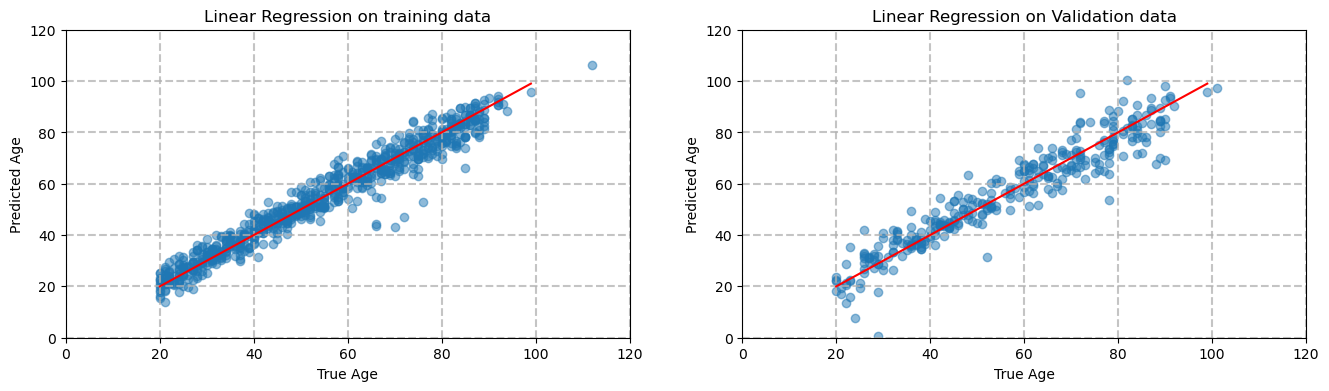

The rms on the training data is 4.641 years
The rms on the validation data is 6.598 years
The r^2 on the training data is 0.949
The r^2 on the validation data is 0.897
The MAe on the training data is 3.366 years
The MAE on the validation data is 4.794


In [34]:
plt.rcdefaults()
mod_100, rms_train, rms_test, r2_train, r2_test = linear_regress(X_train, y_train, X_test, y_test, plot=True)

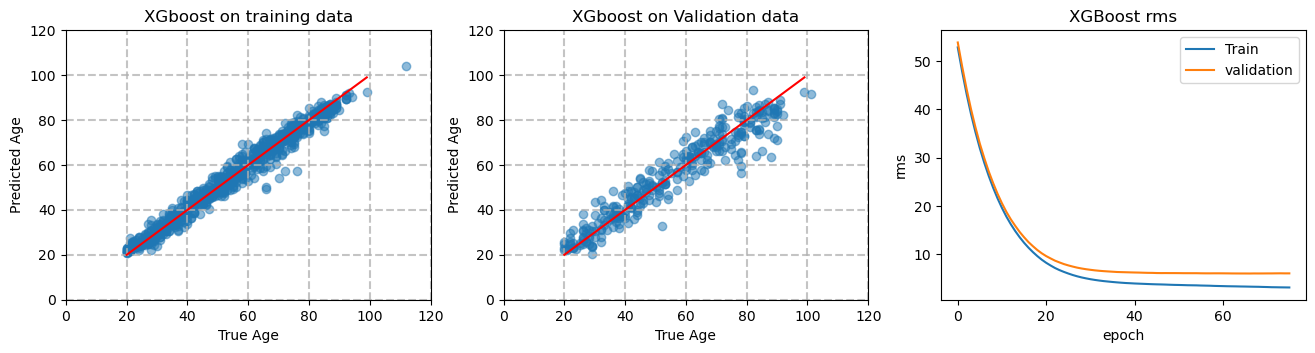

The number of training epochs was 76
The rms on the training data is 3.329 years
The rms on the validation data is 6.047 years
The r^2 on the training data is 0.974
The r^2 on the validation data is 0.914
The MAE on the training data is 2.512 years
The MAE on the validation data is 4.486 years


In [35]:
XG_100, rms_train, rms_test, r2_train, r2_test, feature_importances_ = xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=10, plot=True)

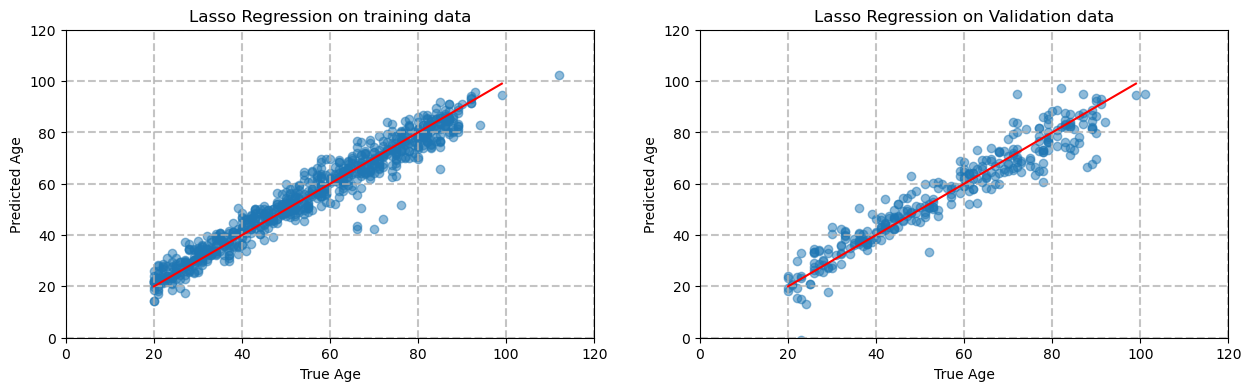

The rms on the training data is 4.908 years
The rms on the validation data is 6.294 years
The r^2 on the training data is 0.943
The r^2 on the validation data is 0.906
The MAE on the training data is 3.546 years
The MAE on the validation data is 4.526 years
Optimal alpha from CV = 0.01


In [36]:
 mod_lasso_100, rms_train, rms_test, r2_train, r2_test = lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

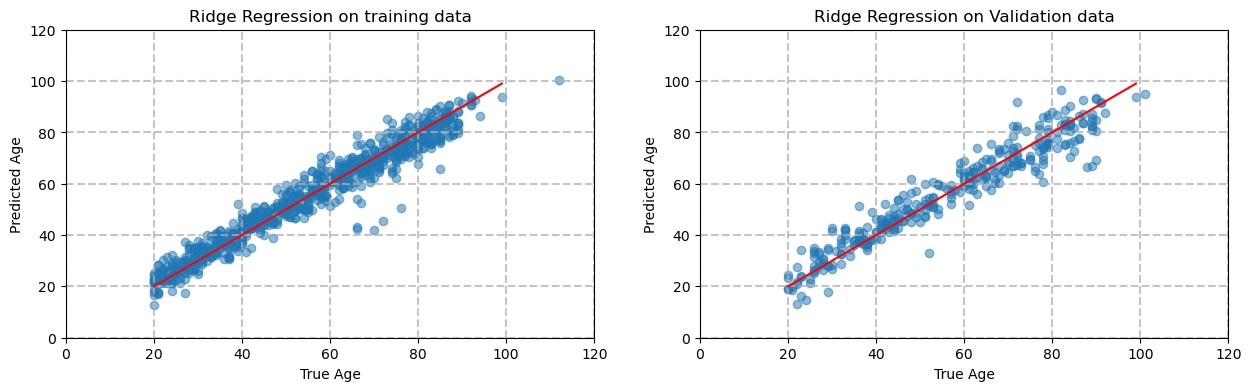

The rms on the training data is 4.913 years
The rms on the validation data is 6.232 years
The r^2 on the training data is 0.943
The r^2 on the validation data is 0.908
The MAE on the training data is 3.555 years
The MAE on the validation data is 4.485 years
Optimal alpha from CV = 1.0


In [37]:
mod_ridge_100, rms_train, rms_test, r2_train, r2_test = ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

In [40]:
# Save models
import pickle

with open(path_to_save_models + 'mod_100_blood_stats', 'wb') as fp:
    pickle.dump(mod_100, fp)
    
with open(path_to_save_models + 'XG_100_blood_stats', 'wb') as fp:
    pickle.dump(XG_100, fp)
    
with open(path_to_save_models + 'mod_lasso_100_blood_stats', 'wb') as fp:
    pickle.dump(mod_lasso_100, fp)
    
with open(path_to_save_models + 'mod_ridge_100_blood_stats', 'wb') as fp:
    pickle.dump(mod_ridge_100, fp)

### Model Perfomance on Heldout Data

In [41]:
X_saved = df_p_saved[Top100_cpgs_statsmodel_blood]
y_saved = df_p_saved.age

In [42]:
plt.rcdefaults()

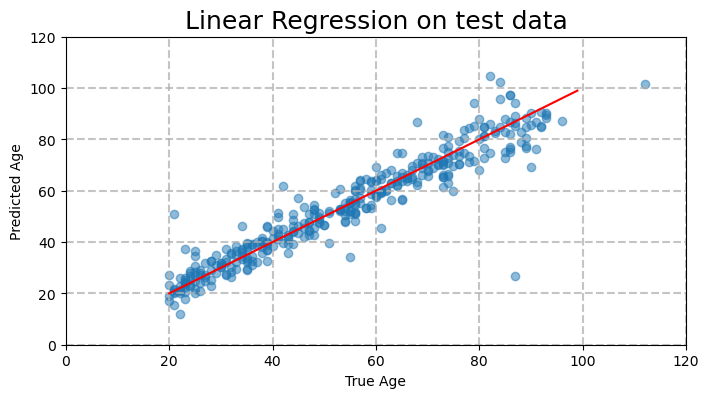

The MSE on Test data is 45.890 years
The rms on Test data is 6.774 years
The r^2 on Test data is 0.898
The mae on Test data is 4.371 years
The correlation on the Test data true-predicted is 0.948


In [45]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_100, mtype='Linear Regression', figsize=(8,4))

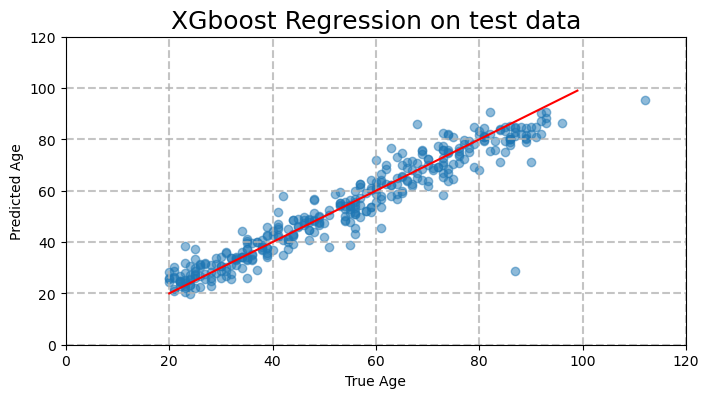

The MSE on Test data is 37.911 years
The rms on Test data is 6.157 years
The r^2 on Test data is 0.916
The mae on Test data is 4.212 years
The correlation on the Test data true-predicted is 0.958


In [46]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, XG_100, mtype='XGboost Regression', figsize=(8,4))

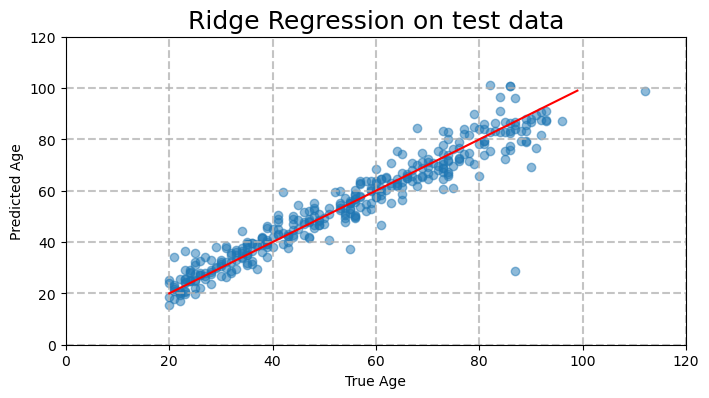

The MSE on Test data is 40.382 years
The rms on Test data is 6.355 years
The r^2 on Test data is 0.910
The mae on Test data is 4.187 years
The correlation on the Test data true-predicted is 0.954


In [47]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_ridge_100, mtype='Ridge Regression', figsize=(8,4))

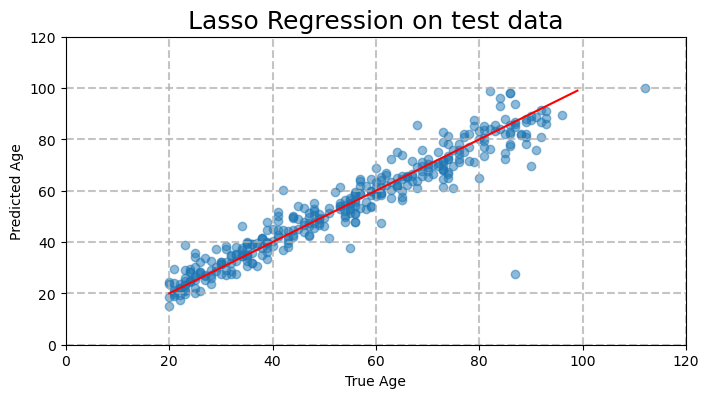

The MSE on Test data is 40.183 years
The rms on Test data is 6.339 years
The r^2 on Test data is 0.911
The mae on Test data is 4.117 years
The correlation on the Test data true-predicted is 0.954


In [48]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_lasso_100, mtype='Lasso Regression', figsize=(8,4))